In [7]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import os
import glob
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Install and import TSFEL for feature extraction
try:
    import tsfel
except ImportError:
    print("Installing TSFEL...")
    import subprocess
    subprocess.check_call(["pip", "install", "tsfel"])
    import tsfel

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

In [8]:
# Load Dataset 
class HARDataLoader:
    def __init__(self, dataset_path):
        self.dataset_path = Path(dataset_path)
        self.activity_labels = {
            'LAYING': 0,
            'SITTING': 1, 
            'STANDING': 2,
            'WALKING': 3,
            'WALKING_DOWNSTAIRS': 4,
            'WALKING_UPSTAIRS': 5
        }
        self.label_to_activity = {v: k for k, v in self.activity_labels.items()}
        
    def load_raw_data(self, data_type='Train'):
        data_path = self.dataset_path / data_type
        
        X_data = []
        y_data = []
        subjects = []
        
        for activity, label in self.activity_labels.items():
            activity_path = data_path / activity
            if not activity_path.exists():
                print(f"Warning: {activity_path} does not exist")
                continue
                
            csv_files = list(activity_path.glob("*.csv"))
            print(f"Found {len(csv_files)} files for {activity}")
            
            for csv_file in csv_files:
                try:

                    subject_id = int(csv_file.stem.split('_')[1])

                    df = pd.read_csv(csv_file)

                    if len(df) >= 500:
                        acc_data = df.iloc[:500, :3].values 
                        flattened_data = acc_data.flatten()
                        
                        X_data.append(flattened_data)
                        y_data.append(label)
                        subjects.append(subject_id)
                    else:
                        print(f"Warning: {csv_file} has less than 500 samples ({len(df)})")
                        
                except Exception as e:
                    print(f"Error loading {csv_file}: {e}")
                    
        return np.array(X_data), np.array(y_data), np.array(subjects)
    
    def load_features_data(self, data_type='Train', feature_file='features.csv'):
        feature_path = self.dataset_path / data_type / feature_file
        
        if not feature_path.exists():
            print(f"Feature file {feature_path} not found")
            return None, None, None
            
        df = pd.read_csv(feature_path)
        
        X = df.iloc[:, :-2].values
        subjects = df.iloc[:, -2].values
        y = df.iloc[:, -1].values
        
        return X, y, subjects
    
    def get_activity_name(self, label):
        """Convert numeric label to activity name"""
        return self.label_to_activity.get(label, f"Unknown_{label}")

dataset_path = "HAR/Combined"  # Change this to your actual dataset path
data_loader = HARDataLoader(dataset_path)

print("Data loader initialized successfully!")
print(f"Activity labels: {data_loader.activity_labels}")

Data loader initialized successfully!
Activity labels: {'LAYING': 0, 'SITTING': 1, 'STANDING': 2, 'WALKING': 3, 'WALKING_DOWNSTAIRS': 4, 'WALKING_UPSTAIRS': 5}


In [9]:
# Load training, test data
try:
    X_train_raw, y_train, subjects_train = data_loader.load_raw_data('Train')
    X_test_raw, y_test, subjects_test = data_loader.load_raw_data('Test')
    
    print(f"Raw data shapes:")
    print(f"Train: X={X_train_raw.shape}, y={y_train.shape}")
    print(f"Test: X={X_test_raw.shape}, y={y_test.shape}")


    print("\nTrying to load pre-computed features...")
    X_train_feat, y_train_feat, subjects_train_feat = data_loader.load_features_data('Train')
    if X_train_feat is not None:
        X_test_feat, y_test_feat, subjects_test_feat = data_loader.load_features_data('Test')
        
        print(f"Feature data shapes:")
        print(f"Train: X={X_train_feat.shape}, y={y_train_feat.shape}")
        print(f"Test: X={X_test_feat.shape}, y={y_test_feat.shape}")
    else:
        print("Pre-computed features not found. Will generate them later.")
        
except Exception as e:
    print(f"Error loading data: {e}")
    print("Please make sure the dataset path is correct and data files exist.")

Found 21 files for LAYING
Found 21 files for SITTING
Found 21 files for STANDING
Found 21 files for WALKING
Found 21 files for WALKING_DOWNSTAIRS
Found 21 files for WALKING_UPSTAIRS
Found 9 files for LAYING
Found 9 files for SITTING
Found 9 files for STANDING
Found 9 files for WALKING
Found 9 files for WALKING_DOWNSTAIRS
Found 9 files for WALKING_UPSTAIRS
Raw data shapes:
Train: X=(126, 1500), y=(126,)
Test: X=(54, 1500), y=(54,)

Trying to load pre-computed features...
Feature file HAR\Combined\Train\features.csv not found
Pre-computed features not found. Will generate them later.


In [10]:
# Utility functions for the assignment

def plot_sample_waveforms(X_data, y_data, data_loader, title="Sample Waveforms"):
    """
    Plot sample waveforms for each activity class
    """
    fig, axes = plt.subplots(6, 1, figsize=(10, 25))
    axes = axes.flatten()
    
    for i, (activity, label) in enumerate(data_loader.activity_labels.items()):
        # Find first sample of this activity
        activity_indices = np.where(y_data == label)[0]
        if len(activity_indices) > 0:
            sample_idx = activity_indices[0]
            sample_data = X_data[sample_idx].reshape(500, 3)  # Reshape to (time, 3_axes)
            
            # Plot the 3 axes
            time = np.arange(500) / 50.0  # Convert to seconds (50Hz sampling)
            axes[i].plot(time, sample_data[:, 0], label='X-axis', alpha=0.7)
            axes[i].plot(time, sample_data[:, 1], label='Y-axis', alpha=0.7)
            axes[i].plot(time, sample_data[:, 2], label='Z-axis', alpha=0.7)
            
            axes[i].set_title(f'{activity}')
            axes[i].set_xlabel('Time (s)')
            axes[i].set_ylabel('Acceleration')
            axes[i].legend()
            axes[i].grid(True, alpha=0.3)
        else:
            axes[i].set_title(f'{activity} (No data)')
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

def calculate_total_acceleration(X_raw):
    """
    Calculate total acceleration from raw accelerometer data
    """
    # Reshape to (samples, time, 3_axes)
    X_reshaped = X_raw.reshape(X_raw.shape[0], 500, 3)
    
    # Calculate total acceleration for each time step
    total_acc = np.sqrt(np.sum(X_reshaped**2, axis=2))
    
    return total_acc

def evaluate_model(model, X_test, y_test, class_names):
    """
    Evaluate model and return metrics
    """
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    return accuracy, precision, recall, f1, cm


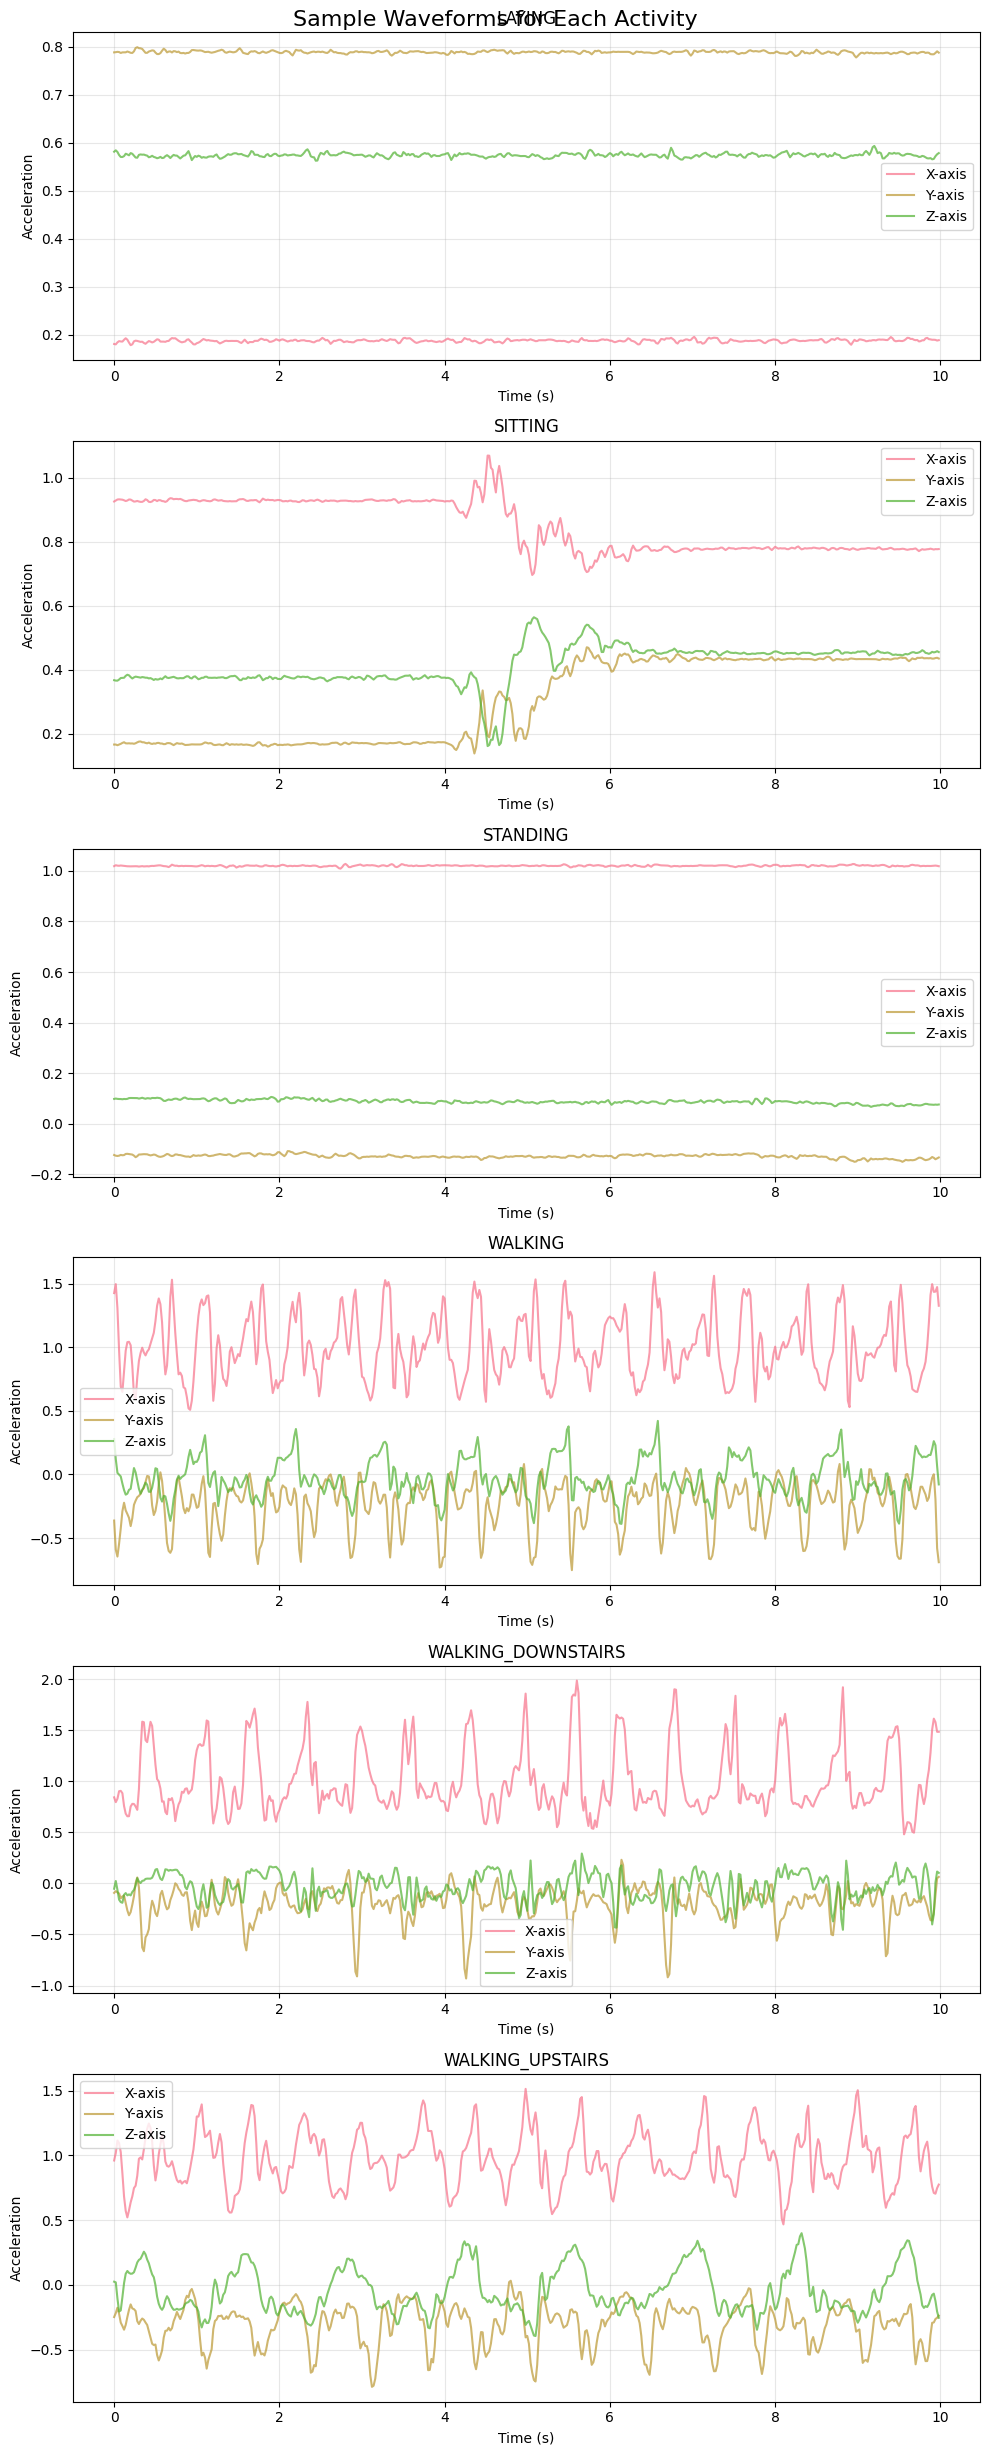

In [11]:
# Question 1: Plot waveforms for each activity class
plot_sample_waveforms(X_train_raw, y_train, data_loader, "Sample Waveforms for Each Activity")

From the Plots we can observe that Dynamic Activities like Walking, Walking Upstairs and Walking Downstairs have component of acceleration in all three axes (x, y, z). In contrast, Static Activities like Sitting and Standing show less variation in acceleration, indicating less movement. This is consistent with our expectations, as dynamic activities typically involve more movement and changes in body position. Yes I believe that model can distinguish well in between static and dynamic activities but distinction between different dynamic activities might be challenging due to their similar patterns.

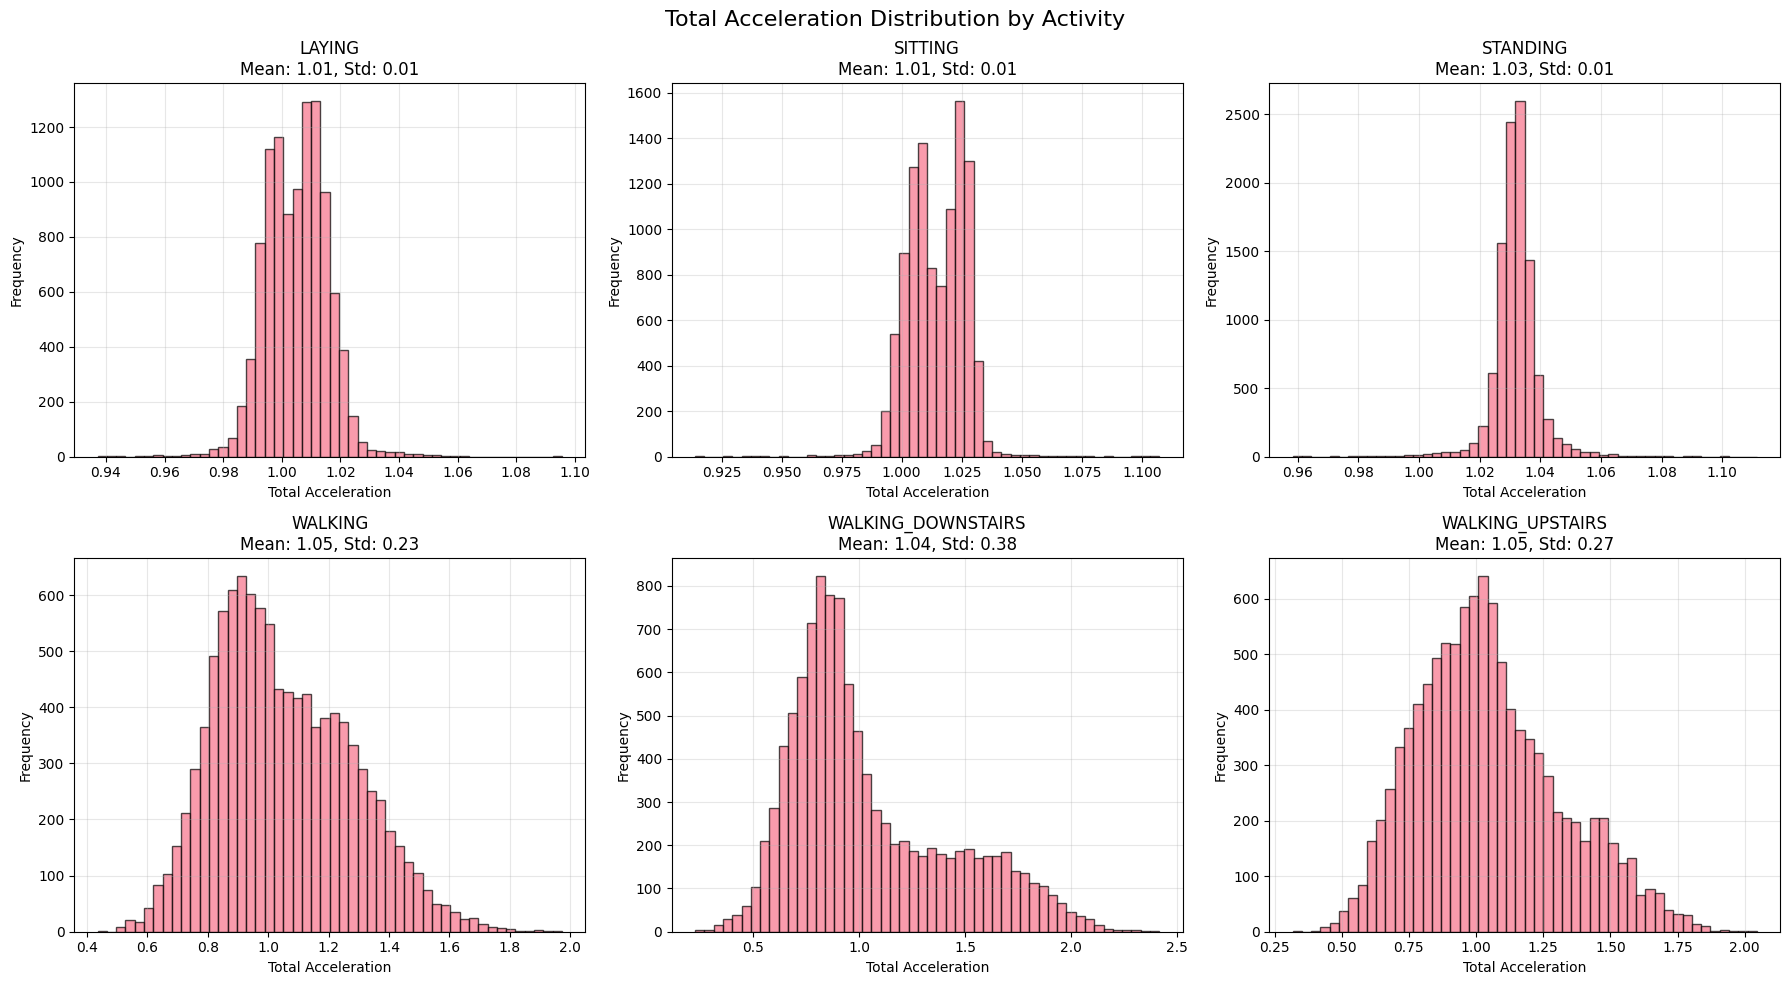


Total Acceleration Analysis:
Activity		Mean		Std		Variance
------------------------------------------------------------
LAYING              	1.005		0.011		0.000
SITTING             	1.014		0.012		0.000
STANDING            	1.032		0.008		0.000
WALKING             	1.050		0.226		0.051
WALKING_DOWNSTAIRS  	1.041		0.378		0.143
WALKING_UPSTAIRS    	1.046		0.268		0.072


In [12]:
# Question 2: Static vs Dynamic Activities Analysis
total_acc_train = calculate_total_acceleration(X_train_raw)

# Calculate statistics for each activity
activity_stats = {}
for activity, label in data_loader.activity_labels.items():
    activity_indices = np.where(y_train == label)[0]
    if len(activity_indices) > 0:
        activity_total_acc = total_acc_train[activity_indices]
        activity_stats[activity] = {
            'mean': np.mean(activity_total_acc),
            'std': np.std(activity_total_acc),
            'variance': np.var(activity_total_acc)
        }

# Plot total acceleration distributions
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, (activity, label) in enumerate(data_loader.activity_labels.items()):
    activity_indices = np.where(y_train == label)[0]
    if len(activity_indices) > 0:
        activity_total_acc = total_acc_train[activity_indices]
        
        # Plot histogram of total acceleration
        axes[i].hist(activity_total_acc.flatten(), bins=50, alpha=0.7, edgecolor='black')
        axes[i].set_title(f'{activity}\nMean: {activity_stats[activity]["mean"]:.2f}, Std: {activity_stats[activity]["std"]:.2f}')
        axes[i].set_xlabel('Total Acceleration')
        axes[i].set_ylabel('Frequency')
        axes[i].grid(True, alpha=0.3)

plt.suptitle('Total Acceleration Distribution by Activity', fontsize=16)
plt.tight_layout()
plt.show()

# Analysis
print("\nTotal Acceleration Analysis:")
print("Activity\t\tMean\t\tStd\t\tVariance")
print("-" * 60)
for activity, stats in activity_stats.items():
    print(f"{activity:<20}\t{stats['mean']:.3f}\t\t{stats['std']:.3f}\t\t{stats['variance']:.3f}")

Total acceleration shape: (126, 500)


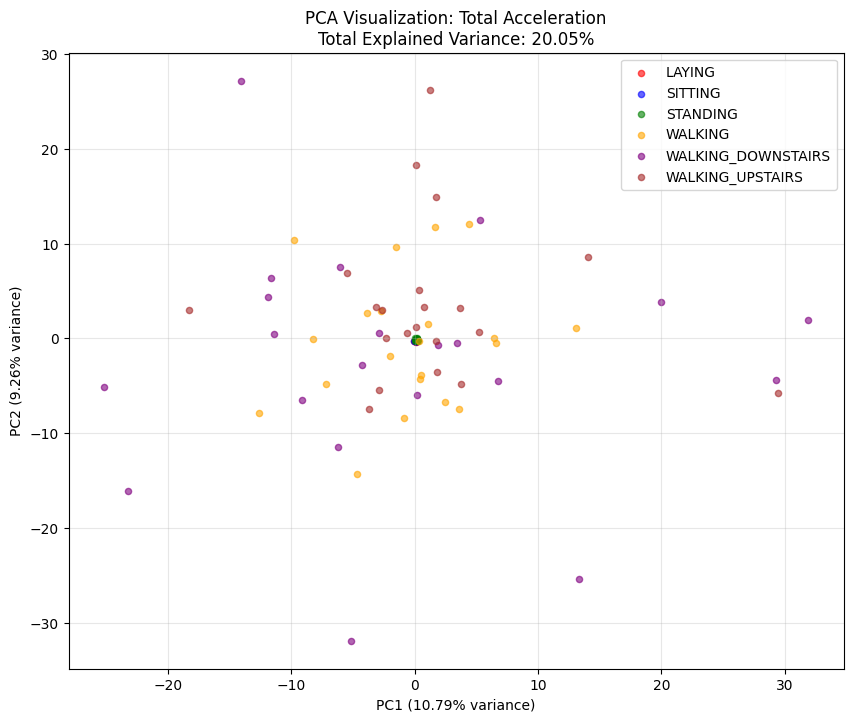

In [44]:
# Question 3: PCA Visualization 

def perform_pca_analysis(features, labels, title, feature_names=None):
    """Perform PCA and create visualization"""
    # Standardize features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    # Apply PCA
    pca = PCA(n_components=2)
    features_pca = pca.fit_transform(features_scaled)
    
    # Plot results
    plt.figure(figsize=(10, 8))
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']
    
    for i, (activity, label) in enumerate(data_loader.activity_labels.items()):
        mask = labels == label
        if np.any(mask):
            plt.scatter(features_pca[mask, 0], features_pca[mask, 1], 
                       c=colors[i], label=activity, alpha=0.6, s=20)
    
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.title(f'{title}\nTotal Explained Variance: {sum(pca.explained_variance_ratio_):.2%}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return pca, features_pca


total_acc_train = calculate_total_acceleration(X_train_raw)
print(f"Total acceleration shape: {total_acc_train.shape}")

pca_total, _ = perform_pca_analysis(
    total_acc_train, y_train, 
    "PCA Visualization: Total Acceleration"
)

Extracting TSFEL features...
TSFEL features shape: (100, 468)
TSFEL features shape: (100, 468)


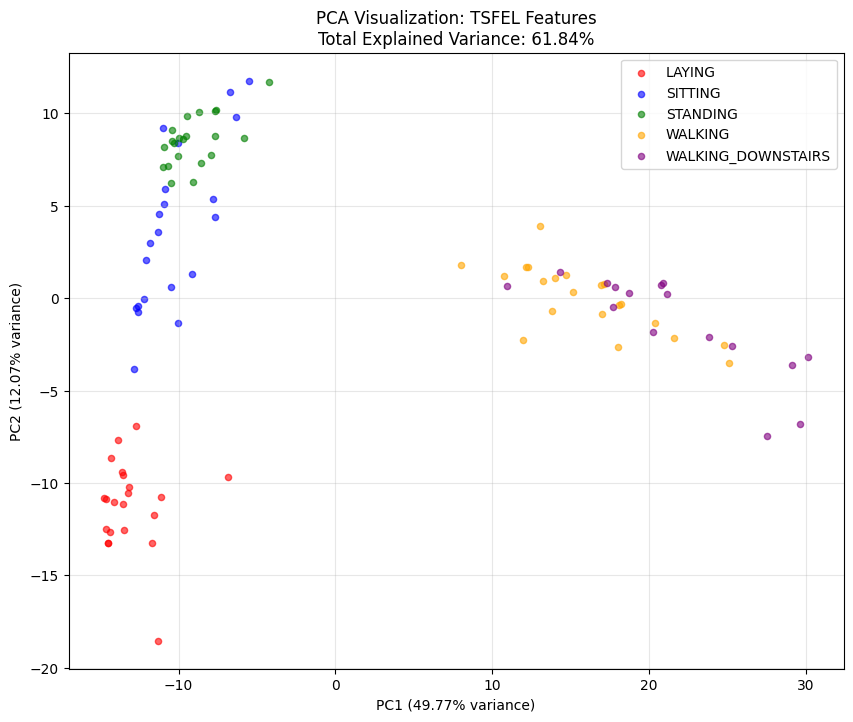

In [45]:
# Question 3: PCA Visualization TSFEL Features

# Configure TSFEL
cfg = tsfel.get_features_by_domain()
tsfel_features = []

print("Extracting TSFEL features...")
for i in range(min(100, len(X_train_raw))):  
    sample = X_train_raw[i].reshape(500, 3)
    sample_df = pd.DataFrame(sample, columns=['acc_x', 'acc_y', 'acc_z'])
    
    try:
        features = tsfel.time_series_features_extractor(cfg, sample_df, verbose=0)
        tsfel_features.append(features.values.flatten())
    except Exception as e:
        print(f"Error extracting features for sample {i}: {e}")
        continue

if len(tsfel_features) > 0:
    tsfel_features = np.array(tsfel_features)
    y_train_subset = y_train[:len(tsfel_features)]
    
    finite_mask = np.isfinite(tsfel_features).all(axis=1)
    tsfel_features_clean = tsfel_features[finite_mask]
    y_train_clean = y_train_subset[finite_mask]
    
    print(f"TSFEL features shape: {tsfel_features_clean.shape}")
    
    pca_tsfel, _ = perform_pca_analysis(
        tsfel_features_clean, y_train_clean,
        "PCA Visualization: TSFEL Features"
    )
else:
    print("Could not extract TSFEL features")

Using raw accelerometer data directly for PCA...
Raw data shape: (126, 1500)


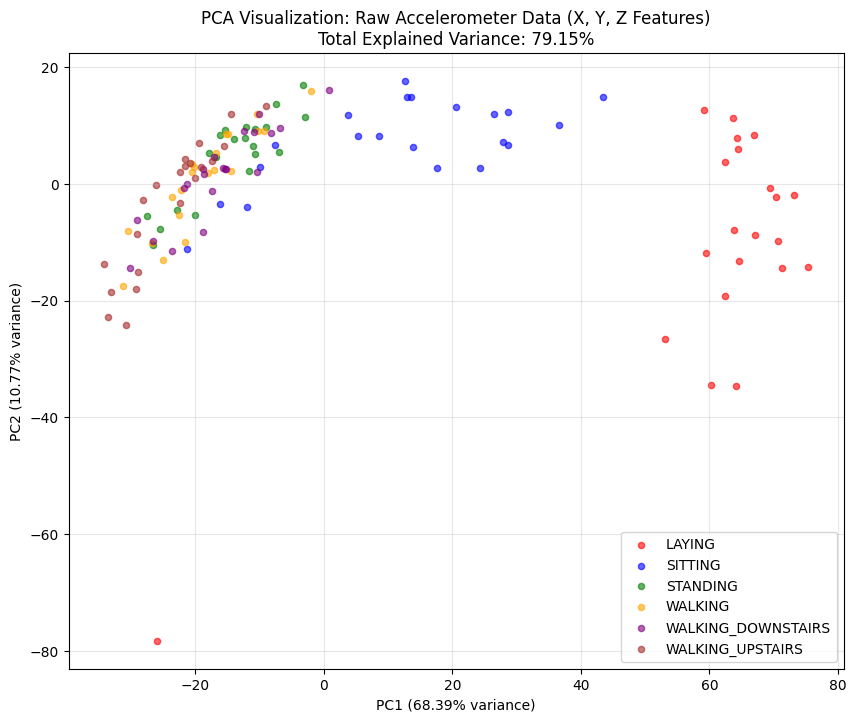

In [46]:
# Question 3: PCA on Raw Accelerometer Data

print("Using raw accelerometer data directly for PCA...")
print(f"Raw data shape: {X_train_raw.shape}")

pca_raw, _ = perform_pca_analysis(
    X_train_raw, y_train,
    "PCA Visualization: Raw Accelerometer Data (X, Y, Z Features)"
)